<a href="https://colab.research.google.com/github/steniodeassis/cellular-galvanotaxis/blob/main/cell-migraton-LSTM-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix Code

For this assignment, we will implement and improve a machine learning model designed by Sargent et al. (2022) to predict the migration of cell under an external electric field (electrotaxis/galvanotaxis) using a recurrent neural network. Since the data used to traing the original model is not available, I used another data set from Arocena et al. (2017) in which the positions of cells were calculated under a electric field of 250 mV/mm. It is important to mention that model was shown to be transferable, since it predicted with high accuracy the migration of another dataset. Therefore, we expected that by training the model in this new data we will not lose accuracy.

Besides that, we will also implement randomness to the original model by adding a noise drawn from a Gaussian distribution to prevent determinism and be more accurate to real biological process of cell migration, where many factors, such as electric, mechanical, thermal, and chemical influence the migration. Here we will only consider cell migration under electric cues, therefore we add noise to be able to better model the cell migration in other unknown conditions. Therefore we should also compare the perfomance of the model between the inclusion and exclusion of ramdon variables.

In [ ]:
# Sargent et al (2022)

import pandas as pd
import numpy as np
import math
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM,Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

# Pre-processing data

The original dataset is composed by the migration in dozens of conditions. For this model we will only consider the migration of wild type cells under electric field in a quartz plane (there is no friction). We desconsider all null values and convert the string numbers back to integers.

In [ ]:
df = pd.read_csv('/content/cell+trajectories+data.csv')

column = 'wt neural progenitor trajectories 250mV/mm flat quartz 9-3-10'
# df.set_index(column, inplace=True)

index_column = list(df.columns).index(column)

# display only the values referent to the interest column
column_indexes = [index_column, index_column+1, index_column+2]
new_df = df.iloc[:,column_indexes]

# replace the column names with the spatial and temporal values
new_df.columns = new_df.iloc[0]
new_df = new_df[1:].reset_index(drop=True)
new_df = new_df.dropna() # clean null values
df = new_df.apply(pd.to_numeric, errors='coerce')

df

,X,Y,time point
0,63.8429,229.958,1
1,63.8429,229.958,2
2,66.3222,229.339,3
3,68.1817,228.719,4
4,76.2396,226.239,5
...,...,...,...
2844,322.9340,298.140,33
2845,328.5120,300.619,34
2846,330.3720,300.619,35
2847,333.4710,301.859,36


The data lists 37 time-series positions of 77 cells. For a better visualization and training, we will decrease the initial position from each position so that all cells start migration from the origin, and we add a cell id, which will be useful when training and testing our model.

In [ ]:
# Add a 'cell_id' column to identify each cell (1 to 77)
df['cell_id'] = (df.index // 37) + 1

# Function to shift positions so each cell starts at the origin
def shift_to_origin(df):
    shifted_data = []
    for cell_id, group in df.groupby('cell_id'):
        # Reset the origin for each cell
        origin_x = group.iloc[0]['X']
        origin_y = group.iloc[0]['Y']

        # Shift coordinates
        group['X'] = group['X'] - origin_x
        group['Y'] = group['Y'] - origin_y
        shifted_data.append(group)

    return pd.concat(shifted_data)

# Apply the function to shift positions
df_shifted = shift_to_origin(df)

# Display the updated DataFrame
print(df_shifted)

0           X      Y  time point  cell_id
0      0.0000  0.000           1        1
1      0.0000  0.000           2        1
2      2.4793 -0.619           3        1
3      4.3388 -1.239           4        1
4     12.3967 -3.719           5        1
...       ...    ...         ...      ...
2844  17.9760 -1.240          33       77
2845  23.5540  1.239          34       77
2846  25.4140  1.239          35       77
2847  28.5130  2.479          36       77
2848  30.3720  2.479          37       77

[2849 rows x 4 columns]


# Data Visualization

Below we see the migrations of cells.

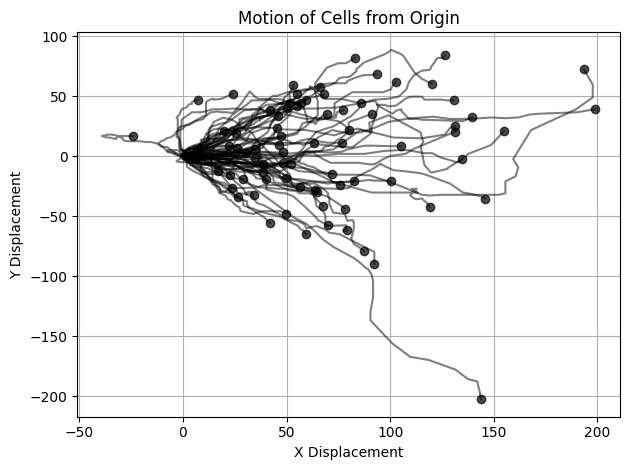

In [ ]:
cells = 77
in_cols = ['X', 'Y']
out_cols = ['X', 'Y']

for cell_idx in range(cells):  # Iterate through 77 cells
    # Each cell has 37 time points, extract corresponding rows
    cell_data = df_shifted.iloc[cell_idx * 37:(cell_idx + 1) * 37]

    x_positions = cell_data['X'].values
    y_positions = cell_data['Y'].values

    plt.plot(cell_data['X'].values,
             cell_data['Y'].values,
             label=f'Cell {cell_idx}',
             alpha=0.5, color='black')

    plt.plot(x_positions[-1], y_positions[-1], marker='o', color='k', alpha=0.7)

plt.title("Motion of Cells from Origin")
plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.grid(True)
plt.tight_layout()
plt.show()


# Splitting Data

Below we split the data into testing, training and validation.

In [ ]:

df = df_shifted
# Function to create dataset for training/testing
def create_dataset(df, lookback=20, in_cols=['X', 'Y'], out_cols=['X', 'Y'], cells=77):
    trainX, trainY = [], []  # Input and output lists

    for cell_idx in range(cells):  # Iterate through 77 cells
        # Each cell has 37 time points, extract corresponding rows
        cell_data = df.iloc[cell_idx * 37:(cell_idx + 1) * 37]
        cell_input = cell_data[in_cols]
        cell_output = cell_data[out_cols]

        # Slide window for lookback
        for i in range(len(cell_data) - lookback):
            trainX.append(cell_input.iloc[i:i + lookback].values)  # Input sequence
            trainY.append(cell_output.iloc[i + lookback].values)   # Output value (next step)

    # Convert lists to numpy arrays
    trainX = np.array(trainX)
    trainY = np.array(trainY)

    return trainX, trainY


In [ ]:
# Generate train, validation, and test sets
trainX, trainY = create_dataset(df.iloc[:50*37], lookback=20)  # First 50 cells for training
valX, valY = create_dataset(df.iloc[50*37:60*37], lookback=20)  # Next 10 cells for validation
testX, testY = create_dataset(df.iloc[60*37:], lookback=20)  # Last 17 cells for testing

print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

(850, 20, 2) (850, 2)
(170, 20, 2) (170, 2)
(289, 20, 2) (289, 2)


# Model: LSTM-RNN

Below we train the data in a LSTM-RNN based on the code of Sargent et al. (2022).

In [ ]:
def typical_model(trainX, trainY, valX, valY, testX, testY, numbers):
    models = []  # List of models
    predictions = []  # List of prediction vectors

    for i in numbers:
        print(f'Training model number {i}')

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(80, input_shape=(20, 2)))  # 20 time steps, 2 features
        model.add(Dense(2))  # Output layer predicts two values: x and y
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Train the model
        model.fit(trainX, trainY, validation_data=(valX, valY), epochs=50, batch_size=1, verbose=1)
        models.append(model)

        # Predict and evaluate RMSE
        trainPredict = model.predict(trainX)
        valPredict = model.predict(valX)
        testPredict = model.predict(testX)

        trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
        valScore = math.sqrt(mean_squared_error(valY, valPredict))
        testScore = math.sqrt(mean_squared_error(testY, testPredict))

        print(f'Training RMSE: {trainScore}, Validation RMSE: {valScore}, Testing RMSE: {testScore}')

        # Append predictions
        predictions.append(np.concatenate([trainPredict, valPredict, testPredict], axis=0))

    return models, predictions


In [ ]:
# Train LSTM models
models, predictions = typical_model(trainX, trainY, valX, valY, testX, testY, numbers=range(1))

# Save the best model (optional)
models[0].save("models/lstm_cell_migration.h5")
print("Model saved to disk.")

Training model number 0
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


850/850 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 2576.5378 - val_loss: 421.5470
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 1172.8574 - val_loss: 165.6267
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 763.1058 - val_loss: 81.8488
Epoch 4/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 358.7076 - val_loss: 57.5214
Epoch 5/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 271.5177 - val_loss: 38.8843
Epoch 6/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 241.8638 - val_loss: 23.5476
Epoch 7/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 159.1287 - val_loss: 19.8255
Epoch 8/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 127.6351 - val_loss: 11.7688
Epoch 9/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 189.8306 - val_loss: 9.7648
Epoch 10/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 98.2364 - val_loss: 11.3498
Epoch 11/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 103.6790 - val_loss: 11.8366
Epoch 12

Training RMSE: 3.5006343623948033, Validation RMSE: 4.005197912295344, Testing RMSE: 2.2699591964381765
Model saved to disk.


# Model Prediction and Accuracy

In [ ]:
# Load trained model
model = models[0]  # Choose the first trained model

# Predict positions for all cells
df['pred_x'] = np.nan
df['pred_y'] = np.nan

lookback = 20
for cell_idx in range(77):  # Iterate through all cells
    cell_data = df.iloc[cell_idx * 37:(cell_idx + 1) * 37]
    x_input = cell_data[['X', 'Y']].values

    # Generate sliding window predictions
    for t in range(lookback, len(cell_data)):
        input_window = x_input[t - lookback:t].reshape(1, lookback, 2)  # Reshape for LSTM
        pred_x, pred_y = model.predict(input_window)[0]

        df.at[cell_idx * 37 + t, 'pred_x'] = pred_x
        df.at[cell_idx * 37 + t, 'pred_y'] = pred_y

# Save the updated DataFrame
df.to_csv('data/cell_migration_predictions.csv', index=False)
print("Predictions saved to file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

Below we can see the prediction along the true values. We see that the values are very similar for the last 17 positions.

In [ ]:
# Create the directory if it doesn't exist
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

# Save the updated DataFrame
file_path = os.path.join(output_dir, 'cell_migration_predictions.csv')
df.to_csv(file_path, index=False)
print(f"Predictions saved to file at {file_path}.")
print("Predictions saved to file.")
print(df.head(40))

Predictions saved to file at data/cell_migration_predictions.csv.
Predictions saved to file.
0          X       Y  time point  cell_id      pred_x     pred_y
0     0.0000   0.000           1        1         NaN        NaN
1     0.0000   0.000           2        1         NaN        NaN
2     2.4793  -0.619           3        1         NaN        NaN
3     4.3388  -1.239           4        1         NaN        NaN
4    12.3967  -3.719           5        1         NaN        NaN
5    14.8760  -6.198           6        1         NaN        NaN
6    21.0744 -11.157           7        1         NaN        NaN
7    27.2727 -10.537           8        1         NaN        NaN
8    32.2314 -12.396           9        1         NaN        NaN
9    40.9091 -14.256          10        1         NaN        NaN
10   46.4871 -13.016          11        1         NaN        NaN
11   50.2061  -9.917          12        1         NaN        NaN
12   50.2061  -6.818          13        1         NaN        N

Below we can visualize how the predictions compare with the real motions of cells. We can see that the predictions are not bad.

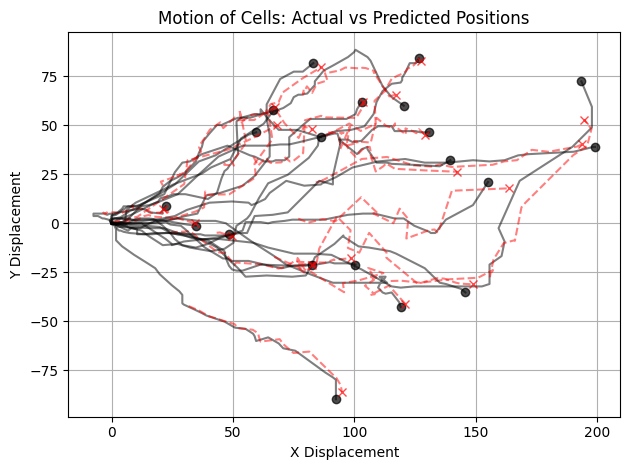

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_shifted is already defined with the provided dataset
cells = 20  # Total number of cells in the dataset
in_cols = ['X', 'Y']
out_cols = ['pred_x', 'pred_y']

for cell_idx in range(cells):  # Iterate through each cell
    # Each cell has 37 time points, extract corresponding rows
    cell_data = df_shifted.iloc[cell_idx * 37:(cell_idx + 1) * 37]

    # Actual positions
    x_positions = cell_data['X'].values
    y_positions = cell_data['Y'].values

    # Predicted positions
    pred_x_positions = cell_data['pred_x'].values
    pred_y_positions = cell_data['pred_y'].values

    # Plot actual positions (in black)
    plt.plot(x_positions, y_positions, label=f'Cell {cell_idx} Actual', alpha=0.5, color='black')
    plt.plot(x_positions[-1], y_positions[-1], marker='o', color='k', alpha=0.7)

    # Plot predicted positions (in red for distinction)
    plt.plot(pred_x_positions, pred_y_positions, label=f'Cell {cell_idx} Predicted', linestyle='--', alpha=0.5, color='red')
    plt.plot(pred_x_positions[-1], pred_y_positions[-1], marker='x', color='red', alpha=0.7)

plt.title("Motion of Cells: Actual vs Predicted Positions")
plt.xlabel("X Displacement")
plt.ylabel("Y Displacement")
plt.grid(True)
# plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.show()


We can see how accurate the model is in predicting the next positions of the cells by the overlapping between the predicted positions and the actual positions. However to quantify the model perfomance we need to discuss numeric metrics. For this purpose we analyse the accuracy

For the accuracy we will use the mean square error (MSE) between the prediction and the real value. Below we see the histogram for MSE and the mean value of 11.17. Indicating that there an error of almost 13 units, which is very low considering that the migration reaches up two magnitudes. There is a global error of 2.1, which is calculated as the mean of the absolute difference between the predicted and the actual positions.

Mean Squared Error (Global): 11.1784


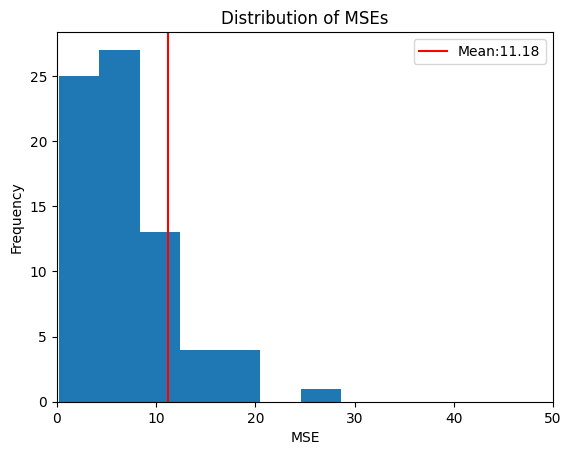

Mean Absolute Error (Global): 2.1020


In [ ]:
# Assuming df_shifted is already defined with the provided dataset
cells = 77  # Total number of cells in the dataset
in_cols = ['X', 'Y']
out_cols = ['pred_x', 'pred_y']

# Store errors and metrics
mse_list = []
accuracies = []
all_actual = []
all_predicted = []

for cell_idx in range(cells):  # Iterate through each cell
    # Each cell has 37 time points, extract corresponding rows
    cell_data = df_shifted.iloc[cell_idx * 37:(cell_idx + 1) * 37]

    # Actual positions
    x_positions = cell_data['X'].values
    y_positions = cell_data['Y'].values

    # Predicted positions
    pred_x_positions = cell_data['pred_x'].values
    pred_y_positions = cell_data['pred_y'].values

    # Filter last 17 positions for comparison
    actual_positions = np.vstack((x_positions[-17:], y_positions[-17:])).T
    predicted_positions = np.vstack((pred_x_positions[-17:], pred_y_positions[-17:])).T

    # Compute MSE
    mse = mean_squared_error(actual_positions, predicted_positions)
    mse_list.append(mse)

    # Collect all actual and predicted values for global metrics
    all_actual.extend(actual_positions)
    all_predicted.extend(predicted_positions)


# Compute global MSE
print(f"Mean Squared Error (Global): {np.mean(mse_list):.4f}")

plt.xlim(0, 50)
plt.hist(mse_list, bins=50)
plt.axvline(np.mean(mse_list), color='red', label=f'Mean:{np.round(np.mean(mse_list), 2)}')
plt.legend()
plt.title("Distribution of MSEs")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()

# Accuracy and Classification Report (Simplified Example for Binary Classification)
all_actual = np.array(all_actual)
all_predicted = np.array(all_predicted)

# Additional Metrics: Example
mae = np.mean(np.abs(all_actual - all_predicted))
print(f"Mean Absolute Error (Global): {mae:.4f}")

# Model: Gaussian Process (GP)

Below we will train the same data in a GP. As discussed, a GP uses kernel to draw sample functions. Below we show how the Kernel Basis Function (KBF) is by showing its heatmap and some samples drawn from it.

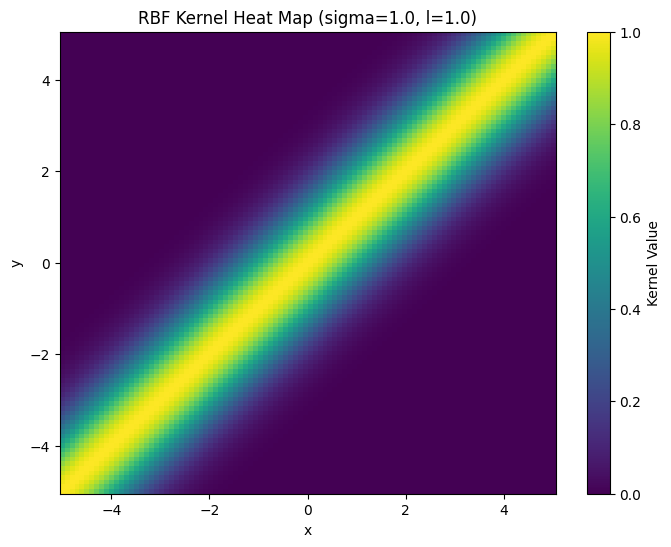

In [ ]:
# Define the RBF kernel function
def rbf_kernel(x, y, sigma=1.0):
    return np.exp(-np.square(x - y) / (2 * sigma**2))

# Create a 1D grid of points
x = np.linspace(-5, 5, 100)  # 100 points from -5 to 5
y = np.linspace(-5, 5, 100)  # Same range for y

# Create a meshgrid for the kernel evaluation
X, Y = np.meshgrid(x, y)

# Evaluate the kernel for all pairs of points
sigma = 1.0  # Set the value of sigma
Z = rbf_kernel(X, Y, sigma)

# Plot the heat map
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
plt.colorbar(c, label='Kernel Value')
plt.title(f"RBF Kernel Heat Map (sigma={sigma}, l=1.0)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


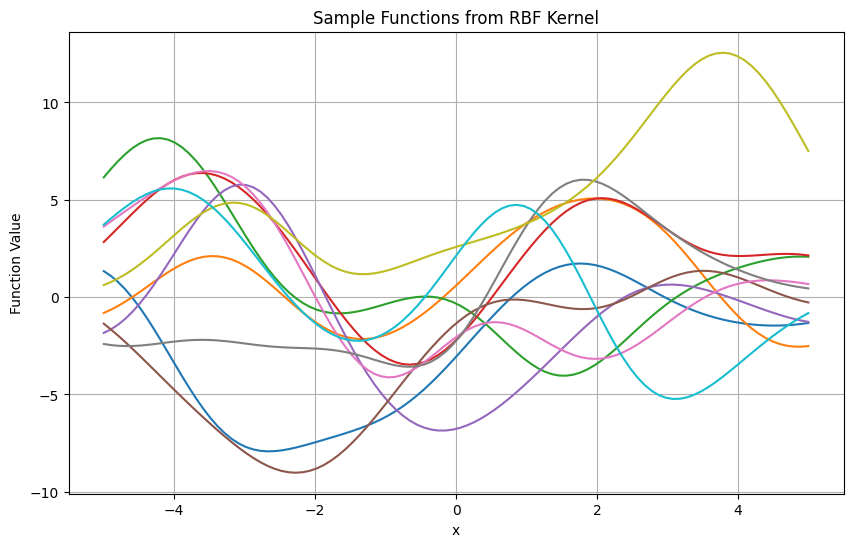

In [ ]:
# Define the RBF kernel function
def rbf_kernel(x, y, sigma=1.0):
    return np.exp(-np.square(x - y) / (2 * sigma**2))

# Create a 1D grid of points
x = np.linspace(-5, 5, 100)  # 100 points from -5 to 5
y = np.linspace(-5, 5, 100)  # Same range for y

# Create a meshgrid for the kernel evaluation
X, Y = np.meshgrid(x, y)

# Evaluate the kernel for all pairs of points
sigma = 1.0  # Set the value of sigma
Z = rbf_kernel(X, Y, sigma)

# Sample functions from the kernel
# Generate a set of random weights to combine kernel values
np.random.seed(42)  # For reproducibility


number_functions = 10  # Number of sample functions to generate
# Plot sample functions
plt.figure(figsize=(10, 6))

for i in range(0, number_functions):
    weights = np.random.randn(len(x))
    # Compute sample functions by summing weighted kernel values
    sample_functions = np.array([np.dot(weights, rbf_kernel(x, xi, sigma)) for xi in x])
    plt.plot(x, sample_functions, label="Sample Function")

plt.title("Sample Functions from RBF Kernel")
plt.xlabel("x")
plt.ylabel("Function Value")
plt.grid()
plt.show()


Below we train the cells in a GP for a single cell and see the difference between the actual path and the predicted path.

<ipython-input-29-9b891ee27f7d>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error: 1996.35016310715
R-squared: -9.682126477009362


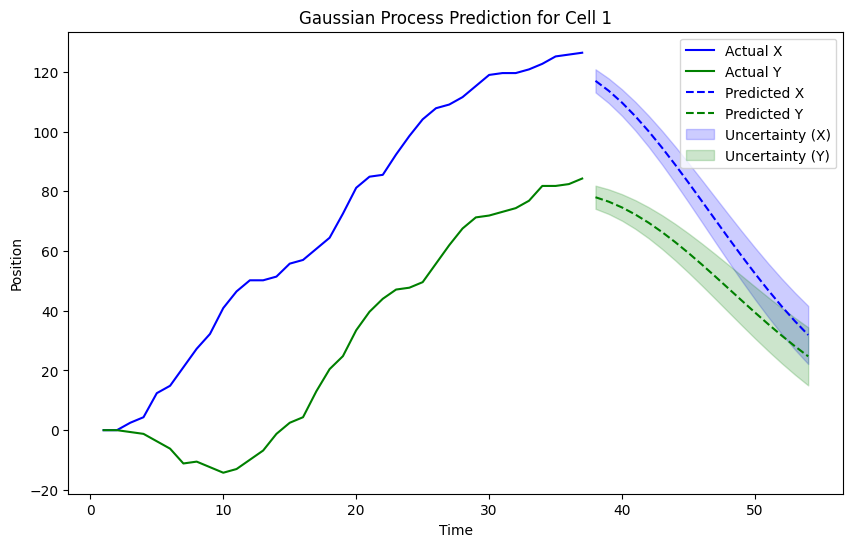

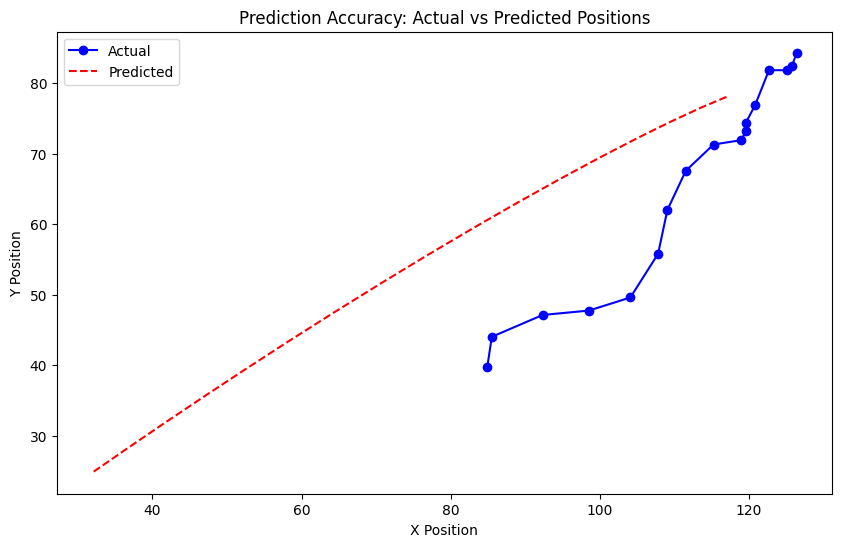

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Load data (assuming a CSV format for simplicity)
data = df

# Prepare data for a specific cell
def prepare_data_for_cell(cell_id, df):
    cell_data = df[df['cell_id'] == cell_id]
    X_time = cell_data['time point'].values.reshape(-1, 1)
    y_position = cell_data[['X', 'Y']].values
    return X_time, y_position

# GP model for a single cell
def train_gp_for_cell(X_train, y_train, X_future):
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    y_pred, y_std = gp.predict(X_future, return_std=True)
    return y_pred, y_std, gp

# Calculate accuracy metrics
def compute_accuracy(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

# Visualize accuracy
def plot_accuracy(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:, 0], y_true[:, 1], 'bo-', label="Actual")
    plt.plot(y_pred[:, 0], y_pred[:, 1], 'r--', label="Predicted")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Prediction Accuracy: Actual vs Predicted Positions")
    plt.legend()
    plt.show()

# Select a specific cell to train and predict
cell_id = 1
X_train, y_train = prepare_data_for_cell(cell_id, data)
X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)

# Train GP and predict
y_pred, y_std, gp_model = train_gp_for_cell(X_train, y_train, X_future)

# Evaluate accuracy for visualization
X_eval = X_train[-17:]
y_eval = y_train[-17:]
mse, r2 = compute_accuracy(y_eval, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualization of predictions
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train[:, 0], 'b-', label="Actual X")
plt.plot(X_train, y_train[:, 1], 'g-', label="Actual Y")
plt.plot(X_future, y_pred[:, 0], 'b--', label="Predicted X")
plt.plot(X_future, y_pred[:, 1], 'g--', label="Predicted Y")
plt.fill_between(X_future.ravel(), y_pred[:, 0] - y_std[:,0], y_pred[:, 0] + y_std[:,0], color='blue', alpha=0.2, label="Uncertainty (X)")
plt.fill_between(X_future.ravel(), y_pred[:, 1] - y_std[:,1], y_pred[:, 1] + y_std[:,1], color='green', alpha=0.2, label="Uncertainty (Y)")
plt.xlabel("Time")
plt.ylabel("Position")
plt.title(f"Gaussian Process Prediction for Cell {cell_id}")
plt.legend()
plt.show()

# Plot accuracy in X-Y space
plot_accuracy(y_eval, y_pred)


Below we train the same model by taking into account all the 77 cells.  

<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


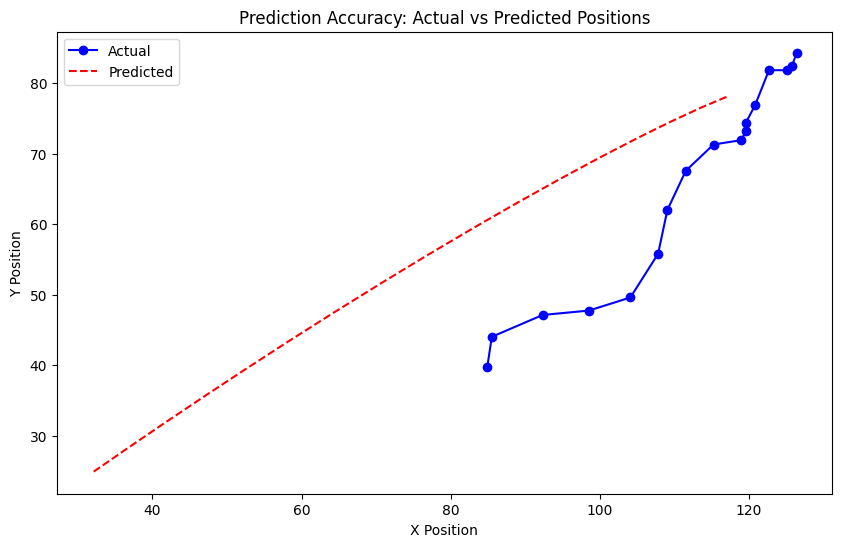

<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


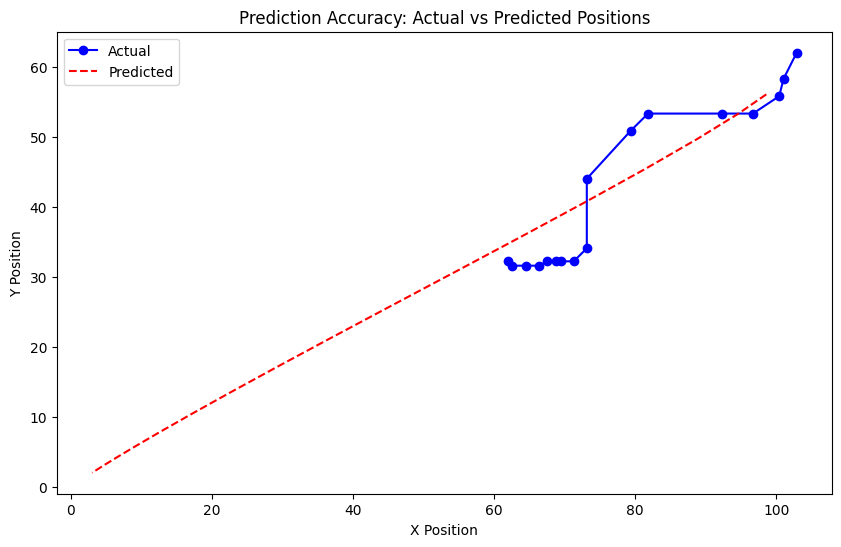

<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


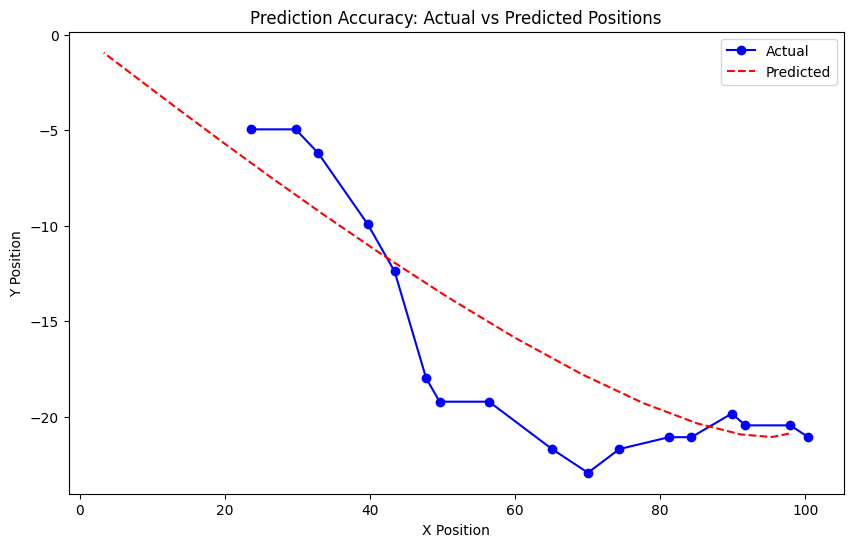

<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)


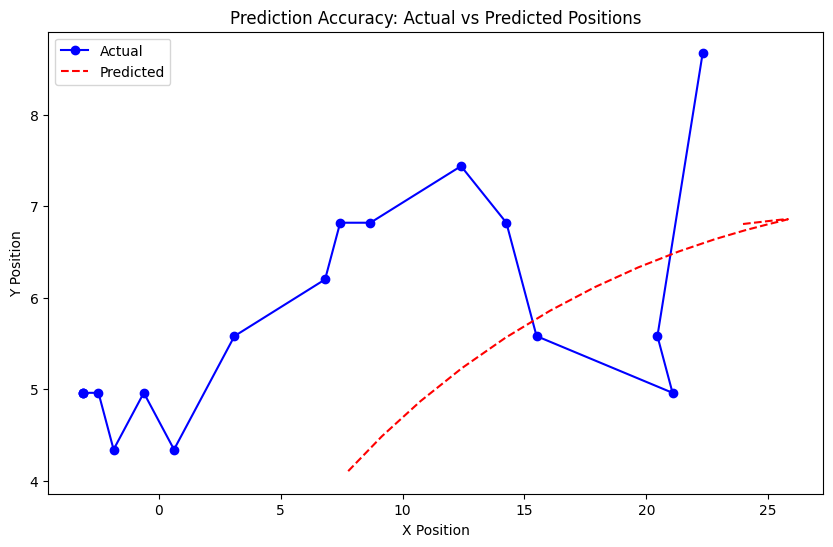

<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-46-5648e933e3ce>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)
/usr/local/lib/python3.10/dist-pa

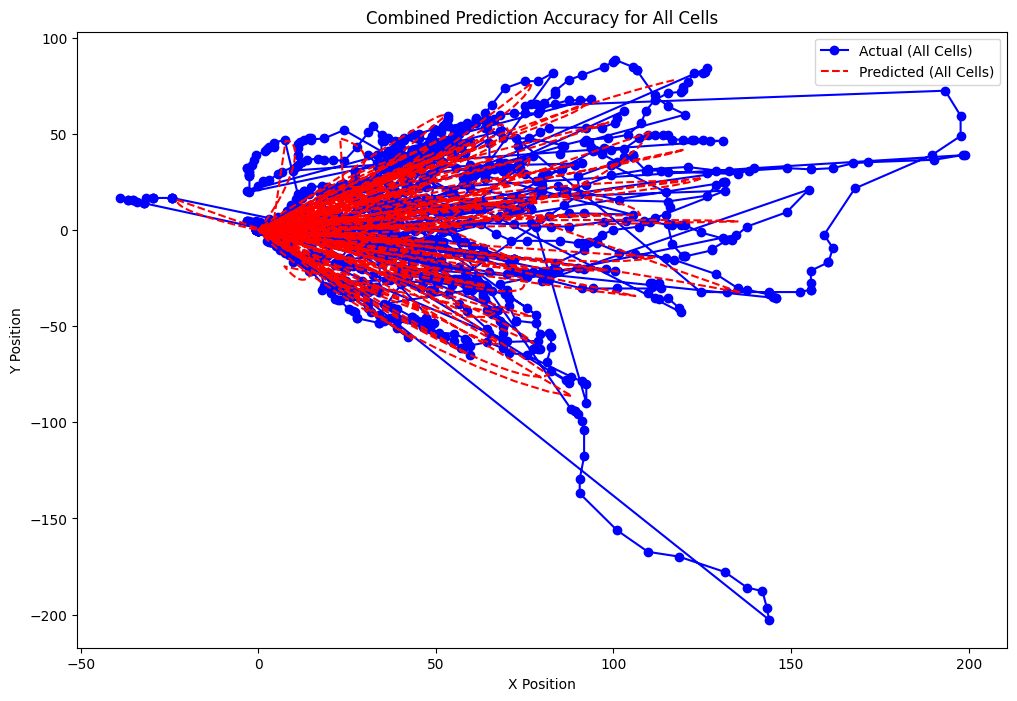

Overall Mean Squared Error: 1258.5072697610574
Overall R-squared: -7.242576702949513e+28


In [ ]:
# Prepare data for a specific cell
def prepare_data_for_cell(cell_id, df):
    cell_data = df[df['cell_id'] == cell_id]
    X_time = cell_data['time point'].values.reshape(-1, 1)
    y_position = cell_data[['X', 'Y']].values
    return X_time, y_position

# GP model for a single cell
def train_gp_for_cell(X_train, y_train, X_future):
    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    y_pred, y_std = gp.predict(X_future, return_std=True)
    return y_pred, y_std, gp

# Calculate accuracy metrics
def compute_accuracy(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

# Visualize accuracy
def plot_accuracy(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:, 0], y_true[:, 1], 'bo-', label="Actual")
    plt.plot(y_pred[:, 0], y_pred[:, 1], 'r--', label="Predicted")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Prediction Accuracy: Actual vs Predicted Positions")
    plt.legend()
    plt.show()

# Train and predict for all cells
all_predictions = []
all_actuals = []
mse_list = []
r2_list = []

for cell_id in data['cell_id'].unique():
    X_train, y_train = prepare_data_for_cell(cell_id, data)
    X_future = np.arange(X_train[-1] + 1, X_train[-1] + 18).reshape(-1, 1)

    y_pred, y_std, gp_model = train_gp_for_cell(X_train, y_train, X_future)

    X_eval = X_train[-17:]
    y_eval = y_train[-17:]

    mse, r2 = compute_accuracy(y_eval, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    all_predictions.append(y_pred)
    all_actuals.append(y_eval)

    # Plot accuracy for each cell
    if cell_id < 5:
        plot_accuracy(y_eval, y_pred)

# Combine predictions for all cells
combined_predictions = np.vstack(all_predictions)
combined_actuals = np.vstack(all_actuals)

plt.figure(figsize=(12, 8))
plt.plot(combined_actuals[:, 0], combined_actuals[:, 1], 'bo-', label="Actual (All Cells)")
plt.plot(combined_predictions[:, 0], combined_predictions[:, 1], 'r--', label="Predicted (All Cells)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Combined Prediction Accuracy for All Cells")
plt.legend()
plt.show()

print(f"Overall Mean Squared Error: {np.mean(mse_list)}")
print(f"Overall R-squared: {np.mean(r2_list)}")


# Inferences

We can see that there is a very high error of three magnitudes. We can also see that the GP fails to learn the general trend because it is being training for each cell. This could also be caused by a poor choice of kernel. A more descriptive kernel would learn better the pattern of the cells. A way to increase the accuracy of the code is by having more sample of cells, which can be done by using simulated data and to figure out a better kernel to model the localization of cells.

# References

Sargent, B., Jafari, M., Marquez, G. et al. A machine learning based model accurately predicts cellular response to electric fields in multiple cell types. Sci Rep 12, 9912 (2022). https://doi.org/10.1038/s41598-022-13925-4


Arocena, M., Rajnicek, A. M., & Collinson, J. M. (2017). Requirement of
            Pax6
            for the integration of guidance cues in cell migration. Royal Society Open Science, 4(10), 170625. https://doi.org/10.1098/rsos.170625